# Project: Investigate a Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


I have selected the ultimate European soccer database from kaggle. The database consisit of the following :

<ol>
<ul> +25,000 matches </ul>
<ul> +10,000 players </ul>
<ul> 11 European Countries with their lead championship </ul>
<ul> Seasons 2008 to 2016 </ul>
<ul> Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates </ul>
<ul> Team line up with squad formation (X, Y coordinates) </ul>
<ul> Betting odds from up to 10 providers </ul>
<ul>Detailed match events (goal types, possession, corner, cross, fouls, cards etc...) for +10,000 matches </ul>
</ol>

### Questions for Analysis 
<ol>
   <li>Which team has scored the most goal at home ? What is the average player attribute of this team? </li>
   <li>Explore player attributes and find the correlation between the following variables:  </li>
   <ol>
      <li>Player aggression and interceptions</li>
      <li>Player vision and long passing</li>
      <li>Player jumping and heading accuracy</li>
   </ol>
   <li>Which players had the most penalties? What is the player attribute associated with it ?</li>
</ol>

### Importing All the Packages 
In this section, we will import all the needed packages for our analysis

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
import seaborn as sns
import pdb
from scipy.stats import ttest_ind
from pandas.tools.plotting import table 
import xml.etree.ElementTree as et
from collections import OrderedDict
import io


%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

> **Note**: I was planning to use SQLITE library within the udacity jupyter notebook but since
    I don not have the ability to add the library, I decided to run the query using 'DB Browser for SQLITE' and then export the results of the query as CSV file.

#### The query I used to extract the data to answer the first question 

``` mysql
SELECT c.name as country, 
l.name as league, 
m.season, 
m.stage, 
m.date, 
t1.team_long_name as home_team, 
t2.team_long_name as away_team , 
m.home_team_goal, 
m.away_team_goal, 
CASE
    WHEN m.home_team_goal > m.away_team_goal THEN t1.team_long_name
    WHEN m.away_team_goal > home_team_goal THEN t2.team_long_name
    ELSE null
END as winner
FROM match m
INNER JOIN Country c ON m.country_id = c.id
INNER JOIN League l ON m.league_id = l.id
INNER JOIN Team t1 ON m.home_team_api_id = t1.team_api_id 
INNER JOIN Team t2 ON m.away_team_api_id = t2.team_api_id 
```

#### The query I used to extract the data to answer the second question 

``` mysql
SELECT pl.player_fifa_api_id, 
pl.player_name, 
pl.height, 
pl.weight, 
p.aggression,
p.interceptions,
p.vision,
p.long_passing,
p.jumping, 
p.heading_accuracy,
p.overall_rating, 
p.preferred_foot, 
p.ball_control, 
p.balance, 
p.strength, 
p.stamina, 
MAX(p.date) 
FROM Player AS pl 
INNER JOIN Player_Attributes  AS p ON pl.player_fifa_api_id = p.player_fifa_api_id 
GROUP BY p.player_fifa_api_id
```

#### Loading dataset required to answer the first question:

In [2]:
# Load soccer database into q1_df
q1_df = pd.read_csv('q1_soccer_db.csv')
q1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 10 columns):
country           25979 non-null object
league            25979 non-null object
season            25979 non-null object
stage             25979 non-null int64
date              25979 non-null object
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
winner            19383 non-null object
dtypes: int64(3), object(7)
memory usage: 2.0+ MB


#### Loading dataset required to answer the second question:

In [3]:
# Load soccer database into q1_df
q2_df = pd.read_csv('q2_players_attr.csv')
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 17 columns):
player_fifa_api_id    11060 non-null int64
player_name           11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
aggression            11060 non-null int64
interceptions         11060 non-null int64
vision                10582 non-null float64
long_passing          11060 non-null int64
jumping               10582 non-null float64
heading_accuracy      11060 non-null int64
overall_rating        11060 non-null int64
preferred_foot        11060 non-null object
ball_control          11060 non-null int64
balance               10582 non-null float64
strength              11060 non-null int64
stamina               11060 non-null int64
MAX(p.date)           11060 non-null object
dtypes: float64(4), int64(10), object(3)
memory usage: 1.4+ MB


### Data Cleaning Process:

###### Question 1 Cleanliness Process :
Since we have executed the above query, we selected only the needed columns for our analysis which is the following :

<table style="width:70%" align="left">
  <tr>
    <th>Column</th>
    <th>Description</th> 
  </tr>
  <tr>
    <td>country</td>
    <td>The league coutry origin</td> 
  </tr>
  <tr>
    <td>league</td>
    <td>The name of the league</td> 
  </tr>
  <tr>
    <td>season</td>
    <td>The season number</td> 
  </tr>
  <tr>
    <td>stage</td>
    <td>The league stage or round number</td> 
  </tr>
  <tr>
    <td>date</td>
    <td>The date of the match</td> 
  </tr>
  <tr>
    <td>home_team</td>
    <td>The long name of the home team</td> 
  </tr>
  <tr>
    <td>away_team</td>
    <td>The long name of the away team</td> 
  </tr>
  <tr>
    <td>home_team_goal</td>
    <td>Goal for home team</td> 
  </tr>
  <tr>
    <td>away_team_goal</td>
    <td>Goal for away team</td> 
  </tr>
  <tr>
    <td>winner</td>
    <td>Which team wins the match (this is new colmun created when I excuted the  query)</td> 
  </tr>
</table>

**To answer the first question, we don't need the 'Winner' column، So, I'm going to drop this columns from the data frame and then I i'll drop any null rows just to make sure that we have clean data frame:**

In [4]:
# Drop the 'Winner' column from the data frame and drop any na rows
q1_df.drop('winner', axis=1, inplace=True)
q1_df.drop('stage', axis=1, inplace=True)
q1_df.drop('away_team_goal', axis=1, inplace=True)
q1_df.drop('away_team', axis=1, inplace=True)

q1_df.dropna( inplace=True)

# Make sure that you get rid off the unneeded columns and null rows
q1_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 6 columns):
country           25979 non-null object
league            25979 non-null object
season            25979 non-null object
date              25979 non-null object
home_team         25979 non-null object
home_team_goal    25979 non-null int64
dtypes: int64(1), object(5)
memory usage: 1.4+ MB


**As we can see, we need to convert stage to int and date to date and time format**

In [5]:
# Convert stage and date to the correct format
q1_df['date']= pd.to_datetime(q1_df['date'])

# Make sure that you convert both columns 
q1_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 6 columns):
country           25979 non-null object
league            25979 non-null object
season            25979 non-null object
date              25979 non-null datetime64[ns]
home_team         25979 non-null object
home_team_goal    25979 non-null int64
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.4+ MB


###### Question 2 Cleanliness Process :
Since we have executed the above query, we selected only the needed columns for our analysis which is the following :

<table style="width:70%" align="left">
   <tr>
      <th>Column</th>
      <th>Description</th>
   </tr>
   <tr>
      <td>player_fifa_api_id</td>
      <td>unique ID from Fifa</td>
   </tr>
   <td>player_name</td>
   <td>player_name</td>
   </tr>
   <tr>
      <td>height</td>
      <td>height</td>
   </tr>
   <tr>
      <td>weight</td>
      <td>weight</td>
   </tr>
   <tr>
      <td>aggression</td>
      <td>aggression</td>
   </tr>
   <tr>
      <td>interceptions</td>
      <td>interceptions</td>
   </tr>
   <tr>
      <td>vision</td>
      <td>vision</td>
   </tr>
   <tr>
      <td>long_passing</td>
      <td>long_passing</td>
   </tr>
   <tr>
      <td>jumping</td>
      <td>jumping</td>
   </tr>
   <tr>
      <td>heading_accuracy</td>
      <td>heading_accuracy</td>
   </tr>
   <tr>
      <td>overall_rating</td>
      <td>overall_rating</td>
   </tr>
   <tr>
      <td>preferred_foot</td>
      <td>preferred_foot</td>
   </tr>
   <tr>
      <td>ball_control</td>
      <td>ball_control</td>
   </tr>
   <tr>
      <td>balance</td>
      <td>balance</td>
   </tr>
   <tr>
      <td>strength</td>
      <td>strength</td>
   </tr>
   <tr>
      <td>stamina</td>
      <td>stamina</td>
   </tr>
   <tr>
      <td>date</td>
      <td>the latest update date</td>
   </tr>
</table>

**To answer the second  question, I'm going to perform the following :**
<ul>Drop rows contatin null value (like 'vision', 'balance' columns)</ul> 
<ul>Check if there are duplicates and remove them</ul>

***Step 1: Drop any rows containing null value :***

In [6]:
# Drop NA rows
q2_df.dropna( inplace=True)

# Make sure that you get rid off the unneeded columns and null rows
q2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10582 entries, 0 to 11059
Data columns (total 17 columns):
player_fifa_api_id    10582 non-null int64
player_name           10582 non-null object
height                10582 non-null float64
weight                10582 non-null int64
aggression            10582 non-null int64
interceptions         10582 non-null int64
vision                10582 non-null float64
long_passing          10582 non-null int64
jumping               10582 non-null float64
heading_accuracy      10582 non-null int64
overall_rating        10582 non-null int64
preferred_foot        10582 non-null object
ball_control          10582 non-null int64
balance               10582 non-null float64
strength              10582 non-null int64
stamina               10582 non-null int64
MAX(p.date)           10582 non-null object
dtypes: float64(4), int64(10), object(3)
memory usage: 1.5+ MB


***Step 2: Check if there duplicated rows and remove them :***

In [7]:
#check if there are any duplicated rows
len(q2_df[q2_df.duplicated()]) # there are none

#Therefore, we are not going to take further action

0

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1: Which team has scored the most goal at home? What is the average player attribute of this team? 

In [8]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

# Group results by home team and sum all the goals that each team scored
# then reset the index
home_team_result= q1_df.groupby(['home_team']).sum().reset_index()

# After reseting the indexes, we can reindex it using the ascending properties  
home_team_result.sort_values('home_team_goal', ascending=False, inplace=True)

# Get the top 5 team who scored the most 
home_team_result= home_team_result.head(5)

home_team_result

,home_team,home_team_goal
211,Real Madrid CF,505
75,FC Barcelona,495
49,Celtic,389
77,FC Bayern Munich,382
184,PSV,370


***The team who scored the most in home is : Real Madrid CF***
<br>
***Real Madrid*** has scored ***505 goals*** from season ***2008 - 2016***

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning:

'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.



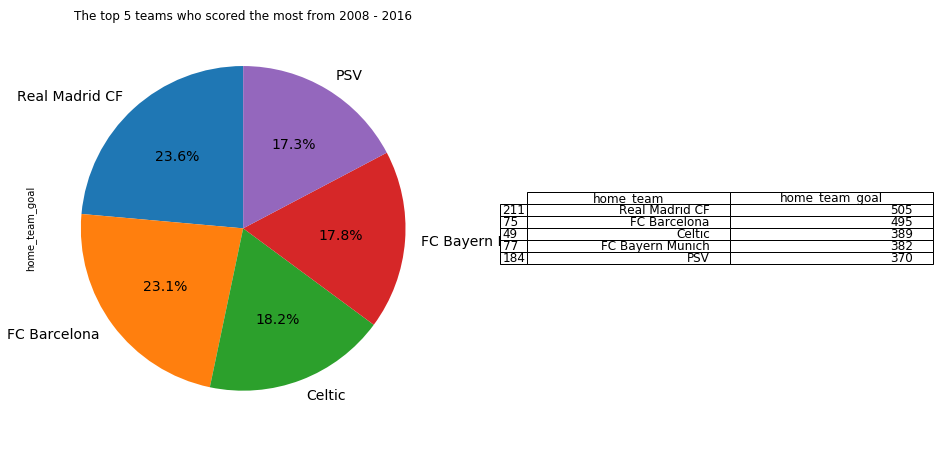

In [22]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
home_team_result.plot(kind='pie', 
                      y = 'home_team_goal', 
                      ax=ax1, 
                      autopct='%1.1f%%', 
                      startangle=90, 
                      shadow=False, 
                      labels=home_team_result['home_team'], 
                      legend = False, 
                      fontsize=14,
                      title= 'The top 5 teams who scored the most from 2008 - 2016')

# plot table
ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, home_team_result, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
plt.show()

### Research Question 2: Explore player attributes and find the correlation between the following variables:   Player aggression and interceptions, Player vision and long passing , Player jumping and heading accuracy

In [10]:
# General overview of the data 
print(q2_df.head())

   player_fifa_api_id        player_name  height  weight  aggression  \
0                   2  Giovanni Pasquale  182.88     181          72   
1                   6     Alessio Scarpi  187.96     183          40   
2                  11      Romain Rocchi  182.88     165          57   
3                  16        Luis Garcia  177.80     152          67   
4                  27           Joe Cole  175.26     161          69   

   interceptions  vision  long_passing  jumping  heading_accuracy  \
0             69    66.0            69     68.0                59   
1             20    42.0            24     72.0                15   
2             58    66.0            64     64.0                54   
3             32    62.0            57     68.0                61   
4             39    74.0            69     58.0                41   

   overall_rating preferred_foot  ball_control  balance  strength  stamina  \
0              69           left            71     68.0        68       69

#### Finding the correlation between aggression and interception

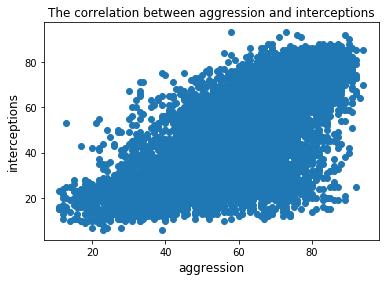

In [16]:
## FInding Relation of aggression/interceptions with Player Attributes
# aggression Vs interceptions
plt.scatter(q2_df['aggression'],q2_df['interceptions'])
plt.xlabel('aggression', fontsize=12)
plt.ylabel('interceptions', fontsize=12)
plt.title('The correlation between aggression and interceptions',fontsize=12)
plt.show()



#### Finding the correlation between player vision and long passing:

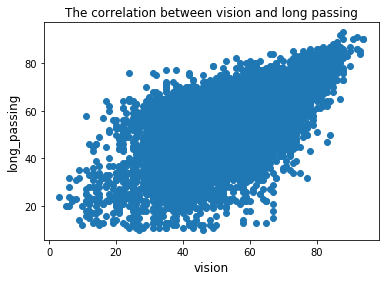

In [12]:
## FInding Relation of vision/long passing with Player Attributes
# vision Vs long passing
plt.scatter(q2_df['vision'],q2_df['long_passing'])
plt.xlabel('vision', fontsize=12)
plt.ylabel('long_passing', fontsize=12)
plt.title('The correlation between vision and long passing',fontsize=12)
plt.show()


#### Finding the correlation between jumping and heading accuracy

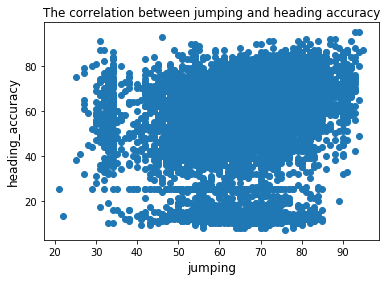

In [46]:
## FInding Relation of vision/long passing with Player Attributes
# vision Vs long passing
df = pd.DataFrame(index=range(1,10) , columns=['empty_column'])
df.fillna(0, inplace= True)

plt.scatter(q2_df['jumping'],q2_df['heading_accuracy'])
plt.xlabel('jumping', fontsize=12)
plt.ylabel('heading_accuracy', fontsize=12)
plt.title('The correlation between jumping and heading accuracy',fontsize=12)
plt.show()




<a id='conclusions'></a>
## Conclusions

### Question 1 conclusion:
The pie chart clearly showing that Real Madrid FC has scored most the goal while playing in his home. They scored 505 goals from 2008 - 2016 season. Their great performance may be indicated that they have many great players along with huge supporters.

### Question 2 Conclusions:
##### aggression Vs interceptions findings:
As we can see from the plot above, there is strong positive correlation between palyer aggression and interception attribute. It does indicate that player with high aggression will most likely will intercept the ball from the opponents. Therefore, as a coach, I will have those kind of players in the middle of field to have privilege over the opponent and intercept the ball and start counter attack.

##### vision Vs long passing findings:
As we can see from the plot above, again there is strong positive correlation between palyer vision and long passing attribute. It does indicate that player with wide vision will most likely will have higher chance of successfully long passing the ball to his team mate in the soccer field. Therefore, if I were a coach, I will put those kind of players as back midfielders

##### jumping Vs heading accuracy findings:
I'm surprised by I saw from the plot above, I though I would strong correlation between jumping and heading accuracy because have better jumping then it would mean that you can reach faster to the ball and you will have better chance to redirect the ball the way you want it. However, the plot above proves my incorrect assumption. The corrleation is weak and not strong 

##### Dataset Limitation:
<li>I was trying to explore different angles of the dataset by I face a great challenge to understand some the columns that extracted from the following website:
http://football-data.mx-api.enetscores.com/
The website is down and to understand some of the columns, you need to spend hefty time to understand it.
</li>
<li>The goal column in 'Match' table is an XML tags which took ages for me to interpret and therefore, I decided not to explore one of the questions I was planning to address "Which players had the most penalties? ".
</li>
<li>Using SQLITE library yet is another challenge because as I explained earlier, I was planning to use SQLITE library in udacity Jypter notebook but could not do it. so, I decided to move on and provide you with SQL query I used to extract my data frame from the table
</li>


## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [14]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0